# 04 - Delivery Routing

This notebook demonstrates the **Router** module for delivery planning and route optimization.

## What we'll do:
1. Load forecasts from previous stage
2. Generate customer locations
3. Distribute demand to customers
4. Assign deliveries to trucks
5. Optimize delivery routes
6. Visualize routes and analyze efficiency

In [1]:
import sys
sys.path.insert(0, '..')

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from router.router import Router

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Imports successful!")

✅ Imports successful!


## 1. Load Forecasts from Previous Stage

In [2]:
# Load forecasts
forecasts = pd.read_csv('../output/02_forecasts.csv')
forecasts['date'] = pd.to_datetime(forecasts['date'])

print(f"📊 Loaded {len(forecasts)} forecast records")
print(f"📅 Date range: {forecasts['date'].min()} to {forecasts['date'].max()}")

# Focus on test period (future forecasts)
test_forecasts = forecasts[forecasts['sample'] == 'test'].copy()
print(f"\n🎯 Test forecasts: {len(test_forecasts)} records")
test_forecasts.head()

📊 Loaded 336 forecast records
📅 Date range: 2024-01-07 00:00:00 to 2025-01-26 00:00:00

🎯 Test forecasts: 24 records


,store,product,date,sales,sample,prediction
52,A,A,2025-01-05,NaN,test,198.04625
53,A,A,2025-01-12,NaN,test,211.04164
54,A,A,2025-01-19,NaN,test,220.02122
55,A,A,2025-01-26,NaN,test,227.03943
108,A,B,2025-01-05,NaN,test,160.91020


## 2. Initialize Router and Generate Customers

In [3]:
# Initialize router
router = Router(
    primary_keys=['store', 'product'],
    date_col='date',
    target_col='sales',
    max_payload=100,
    origin='08020'
)

print("✅ Router initialized")
print(f"   Max Payload: {router.max_payload} units/truck")
print(f"   Origin: {router.origin}")

# Generate customer locations
n_customers = 30
customers = router.generate_customers(n_customers=n_customers)

print(f"\n👥 Generated {len(customers)} customers")
print(f"\nCustomer sample:")
customers.head(10)

✅ Router initialized
   Max Payload: 100 units/truck
   Origin: 08020

👥 Generated 30 customers

Customer sample:


,customer_id,destination
0,CUST_0001,48234
1,CUST_0002,35985
2,CUST_0003,86238
3,CUST_0004,61571
4,CUST_0005,12726
5,CUST_0006,52551
6,CUST_0007,65564
7,CUST_0008,32713
8,CUST_0009,65696
9,CUST_0010,28520


## 3. Distribute Demand to Customers

In [4]:
# Distribute forecasted demand to customers
print("📦 Distributing demand to customers...\n")
deliveries = router.distribute_demand(forecasts)

print(f"✅ Created {len(deliveries)} delivery records")
print(f"\nDelivery columns: {list(deliveries.columns)}")
print(f"\nSample deliveries:")
deliveries.head(10)

📦 Distributing demand to customers...

✅ Created 94 delivery records

Delivery columns: ['store', 'product', 'date', 'sales', 'customer', 'destination', 'units']

Sample deliveries:


,store,product,date,sales,customer,destination,units
0,A,A,2025-01-05,198.04625,CUST_0006,52551,49.511562
1,A,A,2025-01-05,198.04625,CUST_0017,14774,49.511562
2,A,A,2025-01-05,198.04625,CUST_0028,76734,49.511562
3,A,A,2025-01-05,198.04625,CUST_0014,19736,49.511562
4,A,A,2025-01-12,211.04164,CUST_0015,48769,70.347213
5,A,A,2025-01-12,211.04164,CUST_0002,35985,70.347213
6,A,A,2025-01-12,211.04164,CUST_0025,12361,70.347213
7,A,A,2025-01-19,220.02122,CUST_0020,20547,55.005305
8,A,A,2025-01-19,220.02122,CUST_0016,77485,55.005305
9,A,A,2025-01-19,220.02122,CUST_0024,35479,55.005305


In [5]:
# Analyze demand distribution
print("📊 Demand Distribution Analysis:")
print(f"\n   Total demand: {deliveries['units'].sum():.2f} units")
print(f"   Average delivery size: {deliveries['units'].mean():.2f} units")
print(f"   Unique customers: {deliveries['customer'].nunique()}")
print(f"   Unique dates: {deliveries['date'].nunique()}")

# Demand by date
print(f"\n📅 Demand by Date:")
date_summary = deliveries.groupby('date')['units'].agg(['count', 'sum']).round(2)
date_summary.columns = ['# Deliveries', 'Total Units']
print(date_summary)

📊 Demand Distribution Analysis:

   Total demand: 4837.83 units
   Average delivery size: 51.47 units
   Unique customers: 30
   Unique dates: 4

📅 Demand by Date:
            # Deliveries  Total Units
date                                 
2025-01-05            24      1114.43
2025-01-12            22      1195.05
2025-01-19            28      1247.00
2025-01-26            20      1281.36


## 4. Assign Deliveries to Trucks

In [6]:
# Assign trucks based on payload constraints
print("🚚 Assigning deliveries to trucks...\n")
deliveries_with_trucks = router.assign_trucks(deliveries)

n_trucks = deliveries_with_trucks['truck'].nunique()
print(f"✅ Assigned deliveries to {n_trucks} trucks")

# Analyze truck utilization
print(f"\n📊 Truck Utilization:")
truck_summary = deliveries_with_trucks.groupby('truck')['units'].agg(['count', 'sum']).round(2)
truck_summary.columns = ['# Deliveries', 'Total Load']
truck_summary['Utilization %'] = (truck_summary['Total Load'] / router.max_payload * 100).round(1)
print(truck_summary)

🚚 Assigning deliveries to trucks...

✅ Assigned deliveries to 72 trucks

📊 Truck Utilization:
          # Deliveries  Total Load  Utilization %
truck                                            
truck_1              2       95.80           95.8
truck_10             1       72.43           72.4
truck_11             2       70.80           70.8
truck_12             1       72.43           72.4
truck_13             1       55.57           55.6
...                ...         ...            ...
truck_70             1       45.90           45.9
truck_71             1       63.68           63.7
truck_72             1       60.10           60.1
truck_8              1       46.82           46.8
truck_9              1       55.57           55.6

[72 rows x 3 columns]


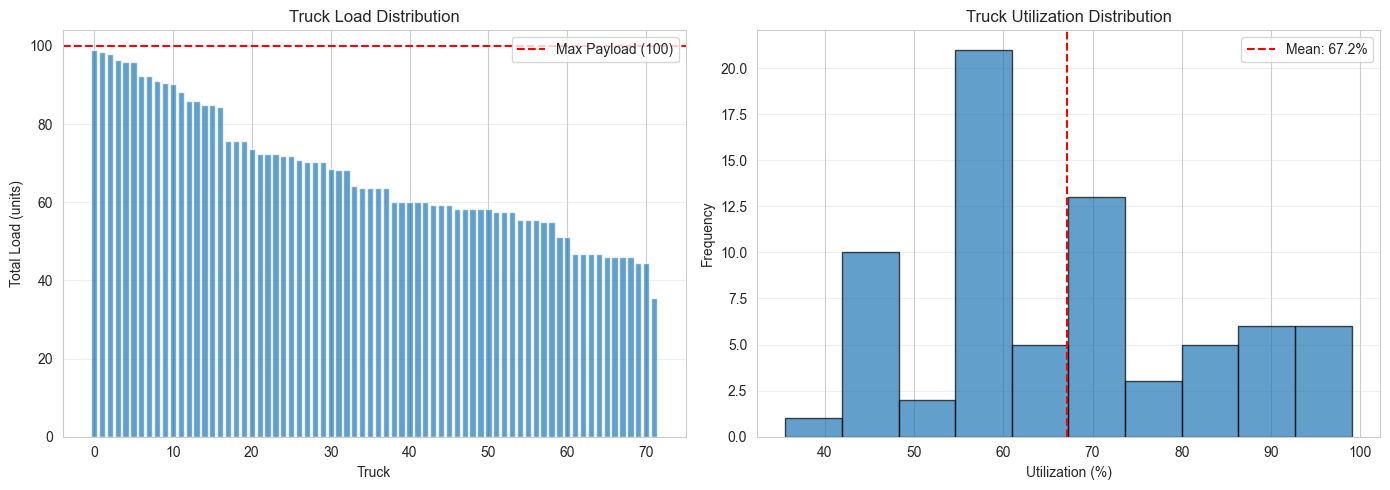

In [7]:
# Visualize truck loads
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart of truck loads
truck_loads = deliveries_with_trucks.groupby('truck')['units'].sum().sort_values(ascending=False)
axes[0].bar(range(len(truck_loads)), truck_loads.values, alpha=0.7)
axes[0].axhline(router.max_payload, color='red', linestyle='--', label=f'Max Payload ({router.max_payload})')
axes[0].set_xlabel('Truck')
axes[0].set_ylabel('Total Load (units)')
axes[0].set_title('Truck Load Distribution')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Histogram of utilization
utilization = (truck_loads / router.max_payload * 100)
axes[1].hist(utilization, bins=10, edgecolor='black', alpha=0.7)
axes[1].axvline(utilization.mean(), color='red', linestyle='--', label=f'Mean: {utilization.mean():.1f}%')
axes[1].set_xlabel('Utilization (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Truck Utilization Distribution')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Optimize Delivery Routes

In [8]:
# Optimize routes using nearest neighbor heuristic
print("🗺️  Optimizing delivery routes...\n")
final_deliveries, routes = router.optimize_routes(deliveries_with_trucks)

print(f"✅ Optimized {len(routes)} routes")
print(f"\nRoute summary:")
print(routes)

🗺️  Optimizing delivery routes...

✅ Optimized 72 routes

Route summary:
       truck route_order origin destinations  total_distance
0    truck_1           1  08020        12361            4341
1   truck_10           1  08020        71723           63703
2   truck_11           1  08020        76167           68147
3   truck_12           1  08020        76167           68147
4   truck_13           1  08020        76734           68714
..       ...         ...    ...          ...             ...
67  truck_70           1  08020        97743           89723
68  truck_71           1  08020        99376           91356
69  truck_72           1  08020        99376           91356
70   truck_8           1  08020        65564           57544
71   truck_9           1  08020        65696           57676

[72 rows x 5 columns]


In [9]:
# Analyze route efficiency
print("📊 Route Efficiency Metrics:")
print(f"\n   Total distance: {routes['total_distance'].sum():.2f} units")
print(f"   Average distance per route: {routes['total_distance'].mean():.2f} units")
print(f"   Min distance: {routes['total_distance'].min():.2f} units")
print(f"   Max distance: {routes['total_distance'].max():.2f} units")

# Deliveries per truck
deliveries_per_truck = final_deliveries.groupby('truck').size()
print(f"\n   Average deliveries per truck: {deliveries_per_truck.mean():.1f}")
print(f"   Min deliveries per truck: {deliveries_per_truck.min()}")
print(f"   Max deliveries per truck: {deliveries_per_truck.max()}")

📊 Route Efficiency Metrics:

   Total distance: 3309722.00 units
   Average distance per route: 45968.36 units
   Min distance: 4341.00 units
   Max distance: 91356.00 units

   Average deliveries per truck: 1.3
   Min deliveries per truck: 1
   Max deliveries per truck: 3


## 6. Visualize Route Metrics

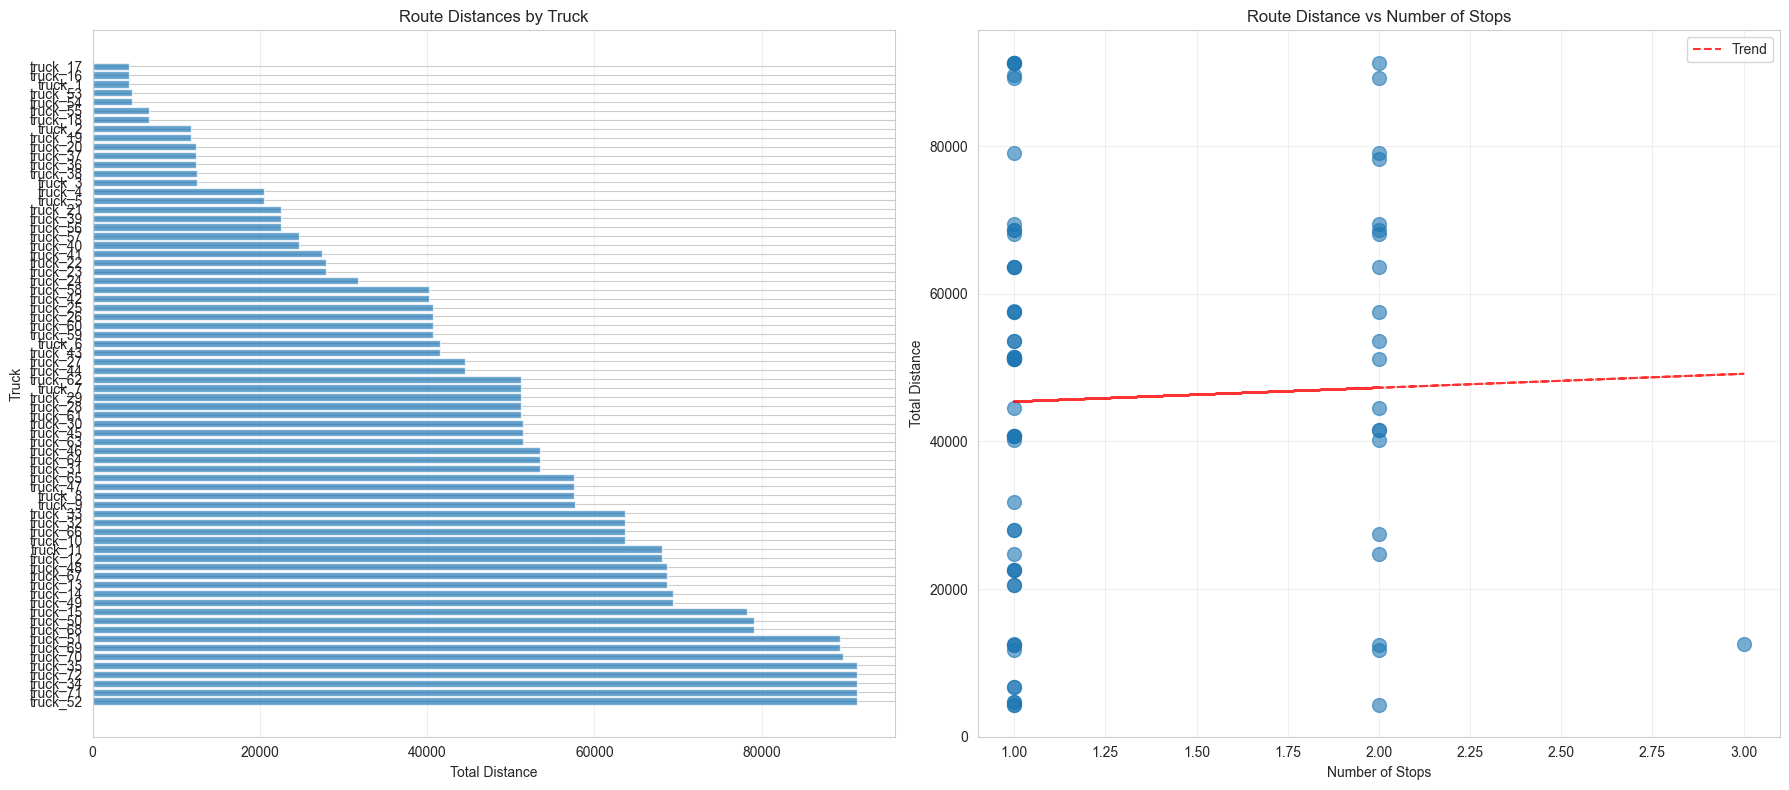

In [10]:
# Plot route distances
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Bar chart of route distances
routes_sorted = routes.sort_values('total_distance', ascending=False)
axes[0].barh(range(len(routes_sorted)), routes_sorted['total_distance'].values, alpha=0.7)
axes[0].set_yticks(range(len(routes_sorted)))
axes[0].set_yticklabels(routes_sorted['truck'].values)
axes[0].set_xlabel('Total Distance')
axes[0].set_ylabel('Truck')
axes[0].set_title('Route Distances by Truck')
axes[0].grid(True, alpha=0.3, axis='x')

# Scatter: Distance vs Number of Stops
stops_per_truck = final_deliveries.groupby('truck').size()
route_data = routes.merge(stops_per_truck.rename('stops'), left_on='truck', right_index=True)

axes[1].scatter(route_data['stops'], route_data['total_distance'], alpha=0.6, s=100)
axes[1].set_xlabel('Number of Stops')
axes[1].set_ylabel('Total Distance')
axes[1].set_title('Route Distance vs Number of Stops')
axes[1].grid(True, alpha=0.3)

# Add trend line
z = np.polyfit(route_data['stops'], route_data['total_distance'], 1)
p = np.poly1d(z)
axes[1].plot(route_data['stops'], p(route_data['stops']), "r--", alpha=0.8, label='Trend')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Analyze Customer Coverage

👥 Top 10 Customers by Volume:
           # Deliveries  Total Units  # Trucks
customer                                      
CUST_0015             5       313.81         5
CUST_0019             6       308.76         5
CUST_0004             5       260.80         4
CUST_0007             5       253.71         5
CUST_0021             5       251.97         5
CUST_0012             4       227.97         4
CUST_0025             4       217.26         3
CUST_0028             4       214.46         4
CUST_0018             5       209.84         4
CUST_0006             4       188.68         3


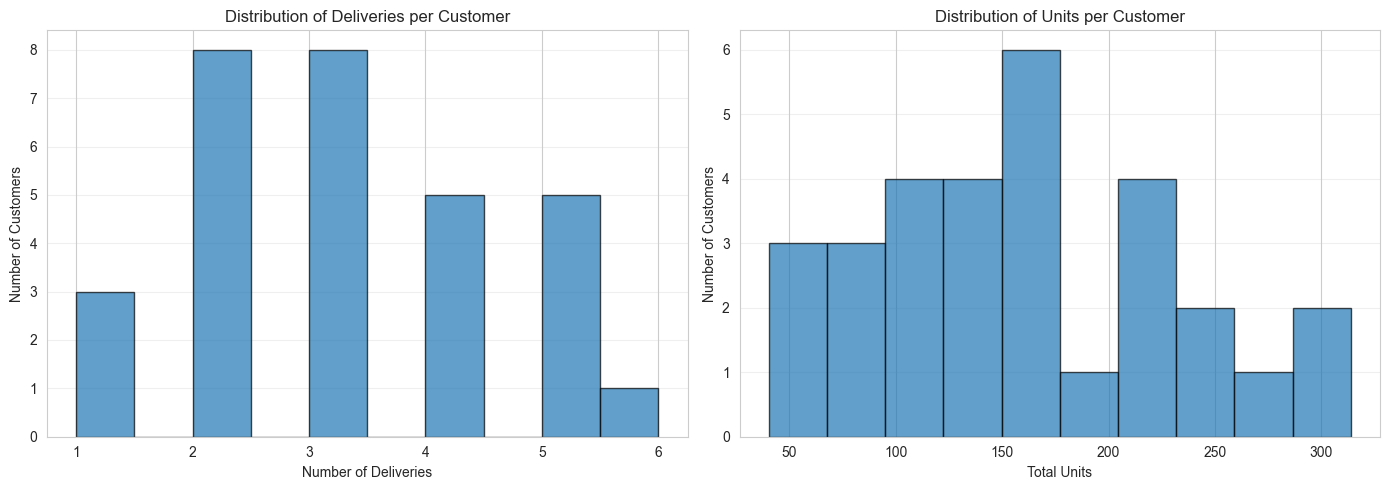

In [11]:
# Which customers receive deliveries?
customer_deliveries = final_deliveries.groupby('customer').agg({
    'units': ['count', 'sum'],
    'truck': 'nunique'
}).round(2)
customer_deliveries.columns = ['# Deliveries', 'Total Units', '# Trucks']
customer_deliveries = customer_deliveries.sort_values('Total Units', ascending=False)

print("👥 Top 10 Customers by Volume:")
print(customer_deliveries.head(10))

# Visualize customer distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Deliveries per customer
axes[0].hist(customer_deliveries['# Deliveries'], bins=10, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of Deliveries')
axes[0].set_ylabel('Number of Customers')
axes[0].set_title('Distribution of Deliveries per Customer')
axes[0].grid(True, alpha=0.3, axis='y')

# Units per customer
axes[1].hist(customer_deliveries['Total Units'], bins=10, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Total Units')
axes[1].set_ylabel('Number of Customers')
axes[1].set_title('Distribution of Units per Customer')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. Save Results

In [12]:
# Save deliveries and routes
deliveries_path = '../output/04_deliveries.csv'
routes_path = '../output/04_routes.csv'

final_deliveries.to_csv(deliveries_path, index=False)
routes.to_csv(routes_path, index=False)

print(f"✅ Deliveries saved to: {deliveries_path}")
print(f"   Total deliveries: {len(final_deliveries)}")
print(f"\n✅ Routes saved to: {routes_path}")
print(f"   Total routes: {len(routes)}")

✅ Deliveries saved to: ../output/04_deliveries.csv
   Total deliveries: 94

✅ Routes saved to: ../output/04_routes.csv
   Total routes: 72


## Summary

✅ Loaded demand forecasts

✅ Generated customer locations

✅ Distributed demand to customers

✅ Assigned deliveries to trucks with payload constraints

✅ Optimized delivery routes using nearest neighbor

✅ Analyzed route efficiency and customer coverage

✅ Saved delivery plan and routes

**Complete!** All stages of the supply chain optimization pipeline have been executed.